# Introduction


## Background

<p> Body fat percentage is a measure of fitness level, which is not easy to obtain during clinical application. A popular way to estimate the body fat is by using the Siri's equation. However, body density is also hard to obtain. 
    
<p> This project aims to come up with a simple, robust, accurate and precise “rule-of-thumb” method to estimate percentage of body fat using clinically available measurements.

## Description of Dataset


### Formula

<p> The Siri's equation for estimating the **body fat B(%)** is

 $$ Body\ Fat\ \%\ (i.e. 100 \times B) = \frac{495}{D} - 450,\ D = Body\ Density\ (gm/cm^{3})$$ 
 

<p> The formula for estimating **ADIPOSITY (BMI)** is
 
$$ADIPOSITY\ (BMI)= \frac{Weight\ (lbs) \times 703}{[Height\ (inch)]^2}$$

### Overview of the dataset

We have **252** observations and **17** variables, their units are given in the parenthesis.
 
* Response variable: Body fat in percentage
* Predictors: Age (years), Weight (lbs), Height (inches), Adiposity (bmi), Neck circumference (cm), Chest circumference (cm), Abdomen circumference (cm), Hip circumference (cm), Thigh circumference (cm), Knee circumference (cm), Ankle circumference (cm), Biceps (extended) circumference (cm), Forearm circumference (cm), Wrist circumference (cm)

# Data Cleaning

Our data cleaning process follows these criteria:

1. Impute those variables which have abnormal values and can be fixed with their redundant variable.
2. Filter out records which are abnormal and cannot be fixed.

## Use Summary Table to Check Extreme Values

We use the summary table to get an overview of the data. What surprises us is the extreme values in some variables

From the summary table, we can see there exist extreme values in the some variables.

<img src="plots/summary.png" alt="Drawing" style="width: 500px;"/>

The observations that have extreme values are 

<img src="plots/data1.png" alt="Drawing" style="width: 750px;"/>

**BODYFAT** is the response variable whose reasonable value ranges from 2% to 39%. 
Individual 172 has lowest possible body fat, which can be considered as essential fat;
Individual 216 is sever obesity, which is possible;
Individual 182, it's impossible to have 0% of bodyfat, and after checking the siri's equation to his density, the corresponding bodyfat becomes negative, thus we filter this records out of our analysis.

There also exists extreme value in **WEIGHT**, which occurs in individual 39. This man also has the largest value in  ADIPOSITY, NECK, CHEST, ABDOMEN, HIP, THIGH, KNEE, BICEPS, and WRIST. Which indicates that this record does exist.

As for **HEIGHT**, individual 42's height is only 29.5 which is quite abnormal. After checking the corresponding weight by BMI formula, we can assume that this is a wrong record. Thus we fix his height by applying the BMI formula.


## Check Siri's Equation

Known that the body fat percentage can be estimated by the density with the Siri's equation. We build a linear model between the bodyfat percentage estimated by Siri's equation and the bodyfat percentage in the data set. The residual plot and the QQ plot of this model is shown below. We can see that record 48, 76, 96 are possible outliers. 

<img src="plots/data2_1.png" alt="Drawing" style="width: 750px;"/>

Individual 96's other variables all have normal value, which indicates his desity might be wrongly recorded.

Individual 48 and 76 have similar values in other variables, thus their body fat percentage should also be similar. Thus we use the Siri's equation to fix their body fat percentage.

## Check the BMI Formula

Known that the ADIPOSITY can be estimated using WEIGHT and HEIGHT. We build a linear model between the BMI estimated by equation and the ADIPOSITY in the data set. The residual plot and the QQ plot of this model is shown below. We can see that record 163, 220, 234 are possible outliers.

<img src="plots/data3_1.png" alt="Drawing" style="width: 750px;"/>

For individual 163, 220, and 234, their weights vary a lot, which means their BMI should not be similar to each other. Thus we adopt the calculated BMI as their ADIPOSITY.

## Data cleaning summary
 
In conclusion:
    
Record **182** is filtered out because it has 0 body fat and there's no way to fix that.
    
The HEIGHT of record **42** is fixed according to the weight and adiposity.
    
The body fat of record **48** and **76** are fixed according to the density.
    
The adiposity of record **163**, **220**, and **234** are fixed according to the weight and height.

# Variable Selection and Statistical Modeling

## Variable Selection 
### Stepwise Backward and Forward LR
Considering there is a tradeoff between model variance and accuracy, we'd better not use all 14 predictors to establish the model. Although the mean square of error (MSE) will be small, the model itself will be unstable. Firstly, we try normal linear regression using the stepwise method to select features. We chose BIC as criterion and directions of forward and backward. The result was shown respectively.

In [19]:
BodyFatData <-read.csv("data/CleanData.csv")
library(MASS)
base=lm(BODYFAT~1,data=BodyFatData[, c(2,4:17)])
full<-lm(BODYFAT~.,data=BodyFatData[, c(2,4:17)])#  use forward stepwise method with BIC, and select four variables in linear regression 
summary(stepAIC(base,scope=list(lower=~1,upper=full),direction = "forward",k=log(249),trace = F))$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-29.9234561,6.69406028,-4.470150,1.193678e-05
ABDOMEN,0.9133283,0.05163326,17.688759,9.869649e-46
WEIGHT,-0.1238172,0.02276101,-5.439883,1.285958e-07
WRIST,-1.4082304,0.40713801,-3.458853,6.391933e-04
FOREARM,0.4253252,0.16733889,2.541700,1.164621e-02


The results of backward and forward method are the same, WEIGHT, ABDOMEN, FOREARM, WRIST were chosen as predictors and they are all significant. R-square of the model is 0.736, which indicates the accuracy of the model is quite good.  However,  in the linear model, collinearity of predictors will increase the variance of model. VIF is a value to identify collinearity. There are collineary between variables if VIF is larger than 5.

In [20]:
library(car)
LR_backward<-lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM, data = BodyFatData[, c(2,4:17)])
print(vif(LR_backward)>5)

ABDOMEN  WEIGHT   WRIST FOREARM 
  FALSE    TRUE   FALSE   FALSE 


The model is still unstable, so we try other methods to do variable selection.

### Variable Selection with XGBoost
XGBoost is an ensemble learning method with tree models. It will output the importance of variables after establishing the model. The criterion for ranking predictors is how many times the variable is chosen as the node in decision trees. The more frequent it is chosen the larger score it will get. Moreover, if the variable is chosen near root of tree, the score will has a large weight because its influence to the decision tree is large.

<img src="plots/xgboost.png" alt="Drawing" style="width: 350px;"/>

## Stable Statistical Model
In both of our methods, we find that ABDOMEN is the most important variable among 14 predictors. WEIGHT ranks high in both methods comparing with other variables. WRIST is significant in linear stepwise model and ADIPOSITY scores high in nonlinear model. Considering the rule of thumb, we select ABDOMEN as our first variable in predicting body fat. Also, to increase the accuracy we choose another variable among WRIST, WEIGHT, ADIPOSITY as our second variable. The number of predictors are too small to use any tree model or ensemble method in machine learning. We still choose normal linear regression as our model. The collinearity are not significant between two variables, so we may not add regulization to our model. After comparing three models, we choose ABDOMEN and WEIGHT as our predictors, because it has highest R-square 0.72.

In [7]:
fit1<-lm(formula = BODYFAT ~ ABDOMEN + WEIGHT, 
            data = BodyFatData[, c("BODYFAT", "WEIGHT", "ABDOMEN")])
summary(fit1)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-40.6768857,2.41526710,-16.841568,5.953549e-43
ABDOMEN,0.9082391,0.05222159,17.392023,7.810903e-45
WEIGHT,-0.1364208,0.01914546,-7.125489,1.124027e-11


## Model Diagnostics & Strength and Weekness
**Final Model:**$$BODYFAT (\%) = 0.908*ABDOMEN(cm) - 0.136*WEIGHT(lb)$$
**Model Diagnostics:**

Firstly, use VIF to check collinearity. There is no obvious collinearity between ABDOMEN and WEIGHT.

In [15]:
print(vif(fit1))

 ABDOMEN   WEIGHT 
4.650949 4.650949 


Then, plot the residuals vs fitted values. Residuals are seperated randomly near 0 and there is no correlation between fitted value and residuals. Also, there is no correlation between residuals and predictors. QQ-plot of residuals show that residuals generally follows normal distribution. It is normal that there are still some outliers in the model.

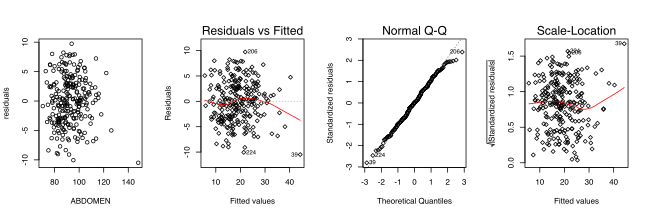

In [31]:
options(jupyter.plot_mimetypes = 'image/svg+xml') 
options(repr.plot.width=9,repr.plot.height=3)
par(mfrow=c(1,4))
plot(BodyFatData$ABDOMEN,residuals(fit1),xlab = "ABDOMEN", ylab = "residuals")
plot(fit1,pch=23,cex=0.9, which = c(1,2,3))

**Strength and Weakness of our model**: 
Generally, this model is a simple, robust, accurate and efficient model, although it also has weaknesses as it cannot capture higher order effects and interactions.
1. Linearity: Residual plot doesn't have a significant pattern.
2. Homoscedasticity: Satisfied by looking at the residual plot.
3. Normality: Normality assumption holds through the QQ plot.
4. Accuracy: The precision of our body fat (\%) prediction is good and it explains 96.2\% of the variation in body fat \% among men.

**Conclusions**: 
Overall, our model provides an easy-to-remember way of estimating the bodyfat % purely based on ABDOMEN, AGE and WRIST. Though it contains three variables, the formula doesn't contain an intercept. AGE is something everyone can remember, and it's easy to measure the ABDOMEN and WRIST using one single tape measure. Moreover, this model is also very precise since it beat many other models on precision.


# Shiny APP

Based on the model above, we developed the shiny app. 

## Extra packages

Beside the "shiny" package, we also used "shinybulma", "grid", "png", "bs4Dash", "rsconnect", "ggplot2", "shinyalert".

## Function

1. Body Fat calculator
2. Size converter(kg to lbs, inch to cm)
3. Detail information about body fat

## Web-based app Link

https://jiawen1014.shinyapps.io/BodyFat/



# Contribution

Jiawen Chen: Web-based App

Chunyuan Jin: Model building and model diagnosing

Han Liao: Data cleaning